# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекc.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Требуется определить рыночную стоимость объектов недвижимости. Наша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

**Описание данных**

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

Файл `real_estate_data.csv`:

     airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
     balcony — число балконов
     ceiling_height — высота потолков (м)
     cityCenters_nearest — расстояние до центра города (м)
     days_exposition — сколько дней было размещено объявление (от публикации до снятия)
     first_day_exposition — дата публикации
     floor — этаж
     floors_total — всего этажей в доме
     is_apartment — апартаменты (булев тип)
     kitchen_area — площадь кухни в квадратных метрах (м²)
     last_price — цена на момент снятия с публикации
     living_area — жилая площадь в квадратных метрах (м²)
     locality_name — название населённого пункта
     open_plan — свободная планировка (булев тип)
     parks_around3000 — число парков в радиусе 3 км
     parks_nearest — расстояние до ближайшего парка (м)
     ponds_around3000 — число водоёмов в радиусе 3 км
     ponds_nearest — расстояние до ближайшего водоёма (м)
     rooms — число комнат
     studio — квартира-студия (булев тип)
     total_area — площадь квартиры в квадратных метрах (м²)
     total_images — число фотографий квартиры в объявлении

**Ход исследования**

Предварительно разделим исследование на этапы:
 1. Обзор данных
 2. Предобработка данных.
 3. Проведение расчётов.
 4. Исследовательский анализ данных.
 
О качестве данных ничего не известно. Поэтому до выполнения расчётов и проведения исследовательского анализа понадобится обзор данных. 

Мы проверим данные на ошибки и оценим их влияние на исследование. Затем, на этапе предобработки мы поищем возможность исправить самые критичные ошибки данных.

## Обзор данных

Составим первое впечатление о данных. Для этого сперва импортируем необходимые библиотеки:

In [1]:
# основная библиотека
import pandas as pd

# отрисовка графиков
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# вспомогательные модули
import os
#pd.options.mode.chained_assignment = None  # отключаем предупреждения Pandas
pd.set_option('display.max_columns', 50)  # выводим все столбцы в таблице (до 50 шт.) 

Прежде мы открыли файл в MS Excel - и обратили внимание, что разделителем в данном датасете выступает не привычная запятая, а значок табуляции.

С учетом этого фактора прочитаем файл `real_estate_data.csv` и сохраним его в переменной `df`:

In [2]:
pth = '/datasets/real_estate_data.csv'

if os.path.exists(pth):
    df = pd.read_csv(pth, sep='\t')
else:
    print(f'Something is wrong in {pth}')

Определим функцию `get_data_info`, которая будет запрашивать из датафрейма:
* 5 первых строк
* информацию о количестве данных в столбцах и их типе
* процентное соотношение пропусков
* описательную статистику

In [3]:
def get_data_info(df):
    print(f'First 5 rows from {pth}')
    display(df.head())
    
    print('\nDataframe info\n')
    display(df.info())
    
    print(f'\nDuplicated rows: {df.duplicated().sum()}\n')
    
    print('\n% of NaN values')
    display(pd.DataFrame(round(df.isna().mean()*100)).style.background_gradient('coolwarm'))
    
    print(f'\nDescriptive statistics\n')
    display(df.describe())

Отобразим информацию о датафрейме при помощи этой функции:

In [4]:
get_data_info(df)

First 5 rows from real_estate_data.csv


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0



Dataframe info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  ai

None


Duplicated rows: 0


% of NaN values


,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,39.000000
floors_total,0.000000
living_area,8.000000
floor,0.000000
is_apartment,88.000000



Descriptive statistics



,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


Выше можно наблюдать следующее:

* Всего в датафрейме двадцать два столбца, большинство из них (кроме `cityCenters_nearest`) поименованы в соответствии с общепринятым стилем. Представленные типы данных - `float`, `int`, `bool` и `object`.


* Подавляющим большинством представлены количественные значения; категории указаны в столбцах `is_apartment`, `studio`, `open_plan` и `locality_name`.


* Дубликатов не обнаружено.


* Пропущенные значения содержатся в столбцах:
  
  *Пользовательские данные:*
  * `ceiling_height`
  * `living_area`
  * `is_apartment`
  * `kitchen_area`
  * `balcony`
  * `days_exposition`
  
  *Картографические данные:*
  * `airports_nearest`
  * `cityCenters_nearest`
  * `parks_around3000`
  * `parks_nearest`
  * `ponds_around3000`
  * `ponds_nearest`


* В описательной статистике наблюдаются аномальные значения - к примеру, минимальная высота потолков в `ceiling_height` составляет 1 м., а максимальная - 100 м.

### Промежуточный вывод
В каждой строке таблицы — данные из объявлений о продаже квартир. Всего представлено двадцать два столбца.

Предварительно можно утверждать, что, данных достаточно для определения рыночной стоимости недвижимости. Однако, во многих столбцах встречаются пропуски. До этапов расчётов и исследовательского анализа необходимо заполнить пропущенные значения - или обосновать их отсутствие.

Интерес представляют и типы данных:
* в столбце `floors_total` указан вещественный тип данных; его оптимальнее перевести в целочисленный, для возможности сравнения со столбцом `floor`;
* столбец `balcony` аналогично лучше перевести в целочисленный формат;
* поскольку столбец `days_exposition` отражает количество дней, то лучший вариант его представления - также целочисленный;
* так как в столбцах `parks_around3000` и `ponds_around3000` значится число парков и прудов соответственно, то их также будет рациональнее перевести в целочисленный формат;
* в документации столбец `is_apartment` указан как булев тип, в таблице же тип его данных указан как `object`;
* столбец с датой публикации `first_day_exposition` удобнее всего будет перевести в формат `datetime`.

Для облегчения работы с данными необходимо также привести наименование столбца `cityCenters_nearest` к общему стилю.

Отдельно отметим, что аномальные значения будут подробно рассматриваться на этапе исследовательского анализа, поэтому в следующем разделе мы не будем на них останавливаться.

## Предобработка данных

### Стиль заголовков
Приведём столбец `cityCenters_nearest` к общему стилю и сохраним результат в текущий датафрейм:

In [5]:
df = df.rename(columns={'cityCenters_nearest': 'city_centers_nearest'})
df.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_centers_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

### Заполнение пропусков

Сразу оговорим, что в данном исследовании мы не будем акцентироваться на заполнении абсолютно всех пропущенных значений. В некоторых случаях заменить их может быть затруднительно, в других же - повлияет на распределение и исказит итоговые выводы. В качестве ориентира примем, что допустимый  процент отсутствия значений в каждом столбце - 1% (за исключением отдельно оговоренных случаев).

Итак, нам известно, что по каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Дабы упорядочить процесс изучения отсутствующих значений примем, что:
1. В первую очередь будут рассматриваться столбцы данных, предоставленные авторами объявлений - `ceiling_height`, `living_area`, `is_apartment`, `kitchen_area`, `balcony`, `days_exposition`;
2. Далее будет изучена картографическая информация - столбцы `airports_nearest`, `city_centers_nearest`, `parks_around3000`, `parks_nearest`, `ponds_around3000`, `ponds_nearest`.

Такое разделение уместно, поскольку в первом типе данных характер пропусков носит случайный характер, а во втором - технологический.

Сперва рассмотрим столбец `is_apartment`:

In [6]:
df.is_apartment.value_counts()

False    2725
True       50
Name: is_apartment, dtype: int64

Как мы видели выше, здесь содержится 88% пропущенных значений, сбросить которые ни в коем случае нельзя. Также, из документации нам известно, что данные в этом столбце должны быть булевого типа, однако здесь они представлены в формате `object`. Последний не только определяет строчный тип данных, но и указывает, что в столбце могут содержаться данные разных типов. В нашем случае это могло указывать на наличие помимо булевых `True` и `False` значений `NaN`, относящихся к типу `float`.

Предположим, что все пропуски - это значения `False`, и заполним их ниже:

In [7]:
df['is_apartment'] = df.is_apartment.fillna(False)

Проверим заполнение пропусков и тип данных в столбце:

In [8]:
print(f'Количество пропусков в is_apartment: {df.is_apartment.isna().sum()}')
print(f'\nТип данных в is_apartment: {df.is_apartment.dtypes}')

Количество пропусков в is_apartment: 0

Тип данных в is_apartment: bool


Наша догадка подтвердилась - а значит, в дальнейшем менять тип данных в этом столбце не потребуется.

Далее рассмотрим столбец с количеством балконов `balcony` и проверим количество уникальных значений в нём:

In [9]:
df.balcony.value_counts()

1.0    4195
0.0    3758
2.0    3659
5.0     304
4.0     183
3.0      81
Name: balcony, dtype: int64

Здесь содержится 49% пропусков. Эти данные вносились пользователем вручную, и можно предположить логичную замену: если человек не указал количество балконов, то, скорее всего, их в квартире нет. Заменим пропуски на `0`:

In [10]:
df['balcony'] = df.balcony.fillna(0)

Проверим отсутствие пропусков:

In [11]:
print(f'Количество пропусков в balcony: {df.balcony.isna().sum()}')

Количество пропусков в balcony: 0


Теперь внимательно рассмотрим столбец `ceiling_height`. Заполнять пропуски здесь логичнее всего медианным значением. Но если это будет медиана по всему столбцу, то мы рискуем усреднить данные и сильно повлиять на распределение. Рациональнее будет заполнить пропущенные значения медианой в разрезе населённого пункта `locality_name`, поскольку высота потолков в разных населённых пунктах варьируется в зависимости от множества факторов (типа застройки, года и т.п.)

Используем метод `fillna()` совместно с группировкой и методом `transform()`. Последний позволит нам модифицировать медианные значения под каждый из населённых пунктов:

In [12]:
df['ceiling_height'] = df.ceiling_height.fillna(df.groupby('locality_name').ceiling_height.transform('median'))

Проверим отсутствие пропусков в столбце:

In [13]:
print(f'Количество пропусков в ceiling_height: {df.ceiling_height.isna().sum()}')

Количество пропусков в ceiling_height: 156


Как мы видим, пропущенные значения присутствуют (хоть и в небольшом количестве) в таблице, несмотря на проведённую выше замену. Изучим эту особенность.

Проведём группировку по населённому пункту - и при помощи агрегатной функции выведем количество значений в столбце `ceiling_height`. Взглянем на последние 10 строк:

In [14]:
(df
 .groupby('locality_name')
 .agg({'ceiling_height':'count'})
 .reset_index()
 .sort_values(by='ceiling_height', ascending=False)
 .tail(10)
)

,locality_name,ceiling_height
158,деревня Щеглово,0
299,посёлок Петро-Славянка,0
297,посёлок Перово,0
162,деревня Ям-Тесово,0
295,посёлок Пансионат Зелёный Бор,0
292,посёлок Мыза-Ивановка,0
165,коттеджный посёлок Лесное,0
171,поселок Володарское,0
172,поселок Гаврилово,0
363,село Шум,0


Исходя из данных группировки можно предположить, что оставшиеся пропуски в `ceiling_height` связаны с тем, что для некоторых населённых пунктов данные по высоте потолков отсутствуют. Именно поэтому медианное значение для этого параметра рассчитать невозможно.

С другой стороны, выше представлены преимущественно посёлки, количество квартир в которых по определению намного меньше, чем в городах. В дальнейшем исследовании мы предпочтём объединить подобные населённые пункты в одну категорию - и проводить расчёты уже по ней. К тому же, как уже упоминалось ранее, количество пропусков невелико, и мы можем допустить их присутствие в датасете.

Теперь изучим столбцы `living_area` и `kitchen_area`. В них содержатся 8% и 10% пропусков, соответственно.

Проверим, есть ли между ними пересечения. Рассмотрим их совместно с общей площадью квартиры `total_area` и сосчитаем, сколько пропусков есть в обоих вышеуказанных столбцах при известной площади квартиры:

In [15]:
df.loc[(df.living_area.isna()) & (df.kitchen_area.isna()), 'total_area'].count()

1464

Квартиры, где не указаны и площадь кухни, и площадь жилой зоны одновременно, присутствуют. Вероятно, имеет смысл рассматривать эти пропуски совместно ещё с одним параметром, учитывающим свободную планировку - `open_plan`. Как мы знаем, при свободной планировке разделение на жилую и кухонную зону может быть весьма условным. Посчитаем, у скольких строк с пропусками значение `open_plan` будет `True`:

In [16]:
df.loc[(df.living_area.isna()) & (df.kitchen_area.isna()), 'open_plan'].value_counts()

False    1459
True        5
Name: open_plan, dtype: int64

Проверим, является ли рассматриваемая недвижимость апартаментами. Сосчитаем, у скольких строк с пропусками значение `is_apartment` будет `True`:

In [17]:
df.loc[(df.living_area.isna()) & (df.kitchen_area.isna()), 'is_apartment'].value_counts()

False    1458
True        6
Name: is_apartment, dtype: int64

Проверим, являются ли эти квартиры студиями. Сосчитаем, у скольких строк с пропусками значение `studio` будет `True`:

In [18]:
df.loc[(df.living_area.isna()) & (df.kitchen_area.isna()), 'studio'].value_counts()

False    1454
True       10
Name: studio, dtype: int64

Выходит, около полутора тысяч квартир с отсутствующими значениями площади кухни и жилой площади в нашей выборке не являются ни студиями, ни апартаментами, ни квартирами со свободной планировкой. Это заставляет усомниться в достоверности предоставленных данных.

В итоге, на данный момент мы не располагаем достаточной информацией по заполнению этих пропущенных значений. Для того, чтобы не исказить грядущую модель автоматизированной системы, лучшим решением будет проверить данные на достоверность и провести повторное исследование.

Относительно пропущенных значений в столбце `days_exposition` можно сказать следующее. В датафрейме представлена дата публикации `first_day_exposition`, но, увы, нет столбца с датой снятия публикации. Также не указана дата составления самого датафрейма. Это делает заполнение пропусков в столбце `days_exposition` крайне затруднительным. Заполнять их медианой по столбцу привело бы к искажению выборки; поэтому рациональным решением будет никак не видоизменять эти пропущенные значения.

Нам осталось рассмотреть пропуски в картографических данных, указанных в столбцах `airports_nearest`, `city_centers_nearest`, `parks_around3000`, `parks_nearest`, `ponds_around3000`, `ponds_nearest`. Как мы видели выше, в них отсутствует от 23% до 66% значений. Ввиду особенностей данной информации мы не можем предложить заполнение их каким бы то ни было медианным значением, и лучшим выходом станет запрос на обогащение данных по вышеуказанным столбцам.

На данном этапе работы с данными мы вынуждены исключить столбцы `airports_nearest`, `city_centers_nearest`, `parks_around3000`, `parks_nearest`, `ponds_around3000`, `ponds_nearest` как факторы влияния на рыночную стоимость жилья. Это необходимо будет учитывать при дальнейшем построении автоматизированной системы.

Напоследок проверим, сколько пропущенных данных осталось после всех внесенных корректив:

In [19]:
pd.DataFrame(round(df.isna().mean()*100)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,1.000000
floors_total,0.000000
living_area,8.000000
floor,0.000000
is_apartment,0.000000


### Изменение типов данных

Ранее мы упоминали, что тип данных в столбце `floors_total` предпочтительнее будет заменить на целочисленный. Однако далее выяснилось, что в данном столбце наличествуют пропуски, имеющие тип данных `float`. Аналогичное можно сказать и о столбцах `days_exposition`, `parks_around3000` и `ponds_around3000` - во всех них также содержатся пропущенные значения. Поскольку мы ранее решили не заполнять пропуски во всех этих столбцах, то возможность изменения типа данных на целочисленный у нас отсутствует.

Двигаемся дальше. Изменим тип данных для столбца `balcony` на целочисленный:

In [20]:
df['balcony'] = df.balcony.astype('int')
print(f'Тип данных в balcony: {df.balcony.dtypes}')

Тип данных в balcony: int32


Для упрощения дальнейшей работы с датой и временем переведём столбец с датой публикации `first_day_exposition` в формат `datetime`. 

Сперва выведем на экран, в каком виде представлена дата в таблице:

In [21]:
df.first_day_exposition.sample()

2994    2018-04-05T00:00:00
Name: first_day_exposition, dtype: object

Далее преобразуем её в тип данных `datetime`:

In [22]:
df['first_day_exposition'] = pd.to_datetime(df.first_day_exposition, format='%Y-%m-%dT%H:%M:%S')
print(f'Тип данных в first_day_exposition: {df.first_day_exposition.dtypes}')

Тип данных в first_day_exposition: datetime64[ns]


Выведем на экран информацию по датафрейму, чтобы проверить внесённые изменения:

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23543 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

### Промежуточный вывод
Предобработка выявила следующие проблемы в данных:

* некорректный стиль представления заголовков
* пропущенные значения
* неудобный тип представления данных

Мы привели заголовки к стандартному виду и изменили тип данных там, где это казалось уместным. Также мы изучили пропущенные значения и предложили рациональные варианты их замены там, где это было возможно. В остальных случаях, для сохранения правдоподобности данных, пропущенные значения были оставлены без изменения.

## Расчёты и добавление результатов в таблицу

### Цена квадратного метра

Рассчитаем и добавим в таблицу цену квадратного метра жилья. Столбец назовём `sqmeter_cost`:

In [24]:
df['sqmeter_cost'] = round(df.last_price / df.total_area, 2)
display(df[['last_price', 'total_area', 'sqmeter_cost']].head())

,last_price,total_area,sqmeter_cost
0,13000000.0,108.0,120370.37
1,3350000.0,40.4,82920.79
2,5196000.0,56.0,92785.71
3,64900000.0,159.0,408176.10
4,10000000.0,100.0,100000.00


### День недели, месяц и год публикации объявления

Поскольку мы заранее изменили тип данных столбца `first_day_exposition` на `datetime`, можно запросить его атрибуты и сохранить их в соответствующие столбцы. 

* **День недели**

Сперва сохраним день недели публикации и проверим, какие уникальные значения там теперь содержатся:

In [25]:
df['weekday'] = df.first_day_exposition.dt.weekday
print(f'Уникальные значения в weekday: {df.weekday.unique()}')

Уникальные значения в weekday: [3 1 4 0 2 6 5]


Вышло не слишком информативно. Понять, к какому дню недели относятся данные цифры нам поможет созданный словарь с расшифровками по дням недели `dict_of_weekdays` и функция `map`:

In [26]:
dict_of_weekdays = {0: 'понедельник', 1: 'вторник', 2: 'среда', 3: 'четверг', 
                    4: 'пятница', 5: 'суббота', 6: 'воскресенье'}

df['weekday'] = df.weekday.map(dict_of_weekdays)

* **Месяц**

Далее сохраним месяц публикации:

In [27]:
df['month'] = df.first_day_exposition.dt.month
print(f'Уникальные значения в month: {df.month.unique()}')

Уникальные значения в month: [ 3 12  8  7  6  9 11  4  5  2  1 10]


Создадим словарь с расшифровками по месяцам и аналогично применим к столбцу функцию `map`:

In [28]:
dict_of_months = {1: 'январь', 2: 'февраль', 3: 'март', 4: 'апрель', 
                    5: 'май', 6: 'июнь', 7: 'июль', 8: 'август', 9: 'сентябрь', 10: 'октябрь', 
                    11: 'ноябрь', 12: 'декабрь'}

df['month'] = df.month.map(dict_of_months)

* **Год**

Наконец, выделим год публикации:

In [29]:
df['year'] = df.first_day_exposition.dt.year
print(f'Уникальные значения в year: {df.year.unique()}')

Уникальные значения в year: [2019 2018 2015 2017 2016 2014]


Выведем первые строки рассматриваемых параметров на экран:

In [30]:
display(df[['first_day_exposition', 'weekday', 'month', 'year']].head())

,first_day_exposition,weekday,month,year
0,2019-03-07,четверг,март,2019
1,2018-12-04,вторник,декабрь,2018
2,2015-08-20,четверг,август,2015
3,2015-07-24,пятница,июль,2015
4,2018-06-19,вторник,июнь,2018


### Этаж квартиры (варианты — первый, последний, другой)

Для того, чтобы разнести этажи по категориям, нам потребуется создать собственную функцию, которая будет сравнивать этаж `floor` с этажностью дома `floors_total`. Определим такую функцию:

In [31]:
def group_floor(row):
    if row['floor'] == 1:
        return 'первый'
    
    elif row['floor'] == row['floors_total']:
        return 'последний'
    
    return 'другой'

Сохраним результаты этой функции в столбец `group_floor`:

In [32]:
df['group_floor'] = df.apply(group_floor, axis=1)
display(df[['floor', 'floors_total', 'group_floor']].head(20))

,floor,floors_total,group_floor
0,8,16.0,другой
1,1,11.0,первый
2,4,5.0,другой
3,9,14.0,другой
4,13,14.0,другой
5,5,12.0,другой
6,6,26.0,другой
7,22,24.0,другой
8,26,27.0,другой
9,7,9.0,другой


### Соотношения площадей

* **Соотношение жилой и общей площади**

Рассчитаем и добавим в таблицу отношение жилой площади к общей. Столбец назовём `living_ratio`:

In [33]:
df['living_ratio'] = round(df.living_area / df.total_area, 2)
display(df[['living_area', 'total_area', 'living_ratio']].head())

,living_area,total_area,living_ratio
0,51.0,108.0,0.47
1,18.6,40.4,0.46
2,34.3,56.0,0.61
3,NaN,159.0,NaN
4,32.0,100.0,0.32


* **Соотношение площади кухни и общей площади**

Рассчитаем и добавим в таблицу отношение площади кухни к общей. Столбец назовём `kitchen_ratio`:

In [34]:
df['kitchen_ratio'] = round(df.kitchen_area / df.total_area, 2)
display(df[['kitchen_area', 'total_area', 'kitchen_ratio']].head())

,kitchen_area,total_area,kitchen_ratio
0,25.0,108.0,0.23
1,11.0,40.4,0.27
2,8.3,56.0,0.15
3,NaN,159.0,NaN
4,41.0,100.0,0.41


### Промежуточный вывод

Мы провели расчёты и добавили в таблицу:
* цену квадратного метра;
* день недели, месяц и год публикации объявления;
* этаж квартиры (варианты — первый, последний, другой);
* соотношение жилой и общей площади, а также отношение площади кухни к общей.

Далее мы проведём подробное исследование предоставленных данных и изучим, насколько им можно доверять и в каких пределах.

## Исследовательский анализ данных

### Изучение площади, цены, числа комнат, высоты потолков

Для начала получим описательную статистику по вышеуказанным столбцам:

In [35]:
df[['total_area', 'last_price', 'rooms', 'ceiling_height']].describe()

,total_area,last_price,rooms,ceiling_height
count,23699.000000,2.369900e+04,23699.000000,23543.000000
mean,60.348651,6.541549e+06,2.070636,2.734102
std,35.654083,1.088701e+07,1.078405,1.012723
min,12.000000,1.219000e+04,0.000000,1.000000
25%,40.000000,3.400000e+06,1.000000,2.550000
50%,52.000000,4.650000e+06,2.000000,2.700000
75%,69.900000,6.800000e+06,3.000000,2.700000
max,900.000000,7.630000e+08,19.000000,100.000000


Исходя из информации выше, можно сказать следующее:
* *площадь недвижимости*

    Общие площади недвижимости представлены в диапазоне от 12 кв. метров до 900 кв. метров. Если первые, вероятно, являются комнатами в общежитиях, то метраж последних вызывает вопросы. Данная площадь больше характерна для особняка, нежели для квартиры. Медианное значение площади составляет 52 кв. метра, что равносильно двухкомнатной квартире.
    
    
* *цены*

    Стоимость квартир колеблется от 12 тысяч (скорее всего, также за комнату, но значение довольно сомнительное) и до 763 млн включительно. Последнее, хоть и теоретически имеет место быть, всё же сильно искажает нашу статистику (стандартное отклонение параметра). Медиана цены на недвижимость - 4.65 млн. На момент исследования (май 2022 г.) она больше характерна для однокомнатных квартир, но поскольку рассматриваемые данные охватывают диапазон до 2019 г., а цены на жильё за это время значительно выросли, то можно предположить, что на тот момент медиана отражала уже упомянутые ранее двухкомнатные квартиры.
    

* *количество комнат*

    Минимальное количество комнат - 0 (характерно для квартир-студий), максимальное - 19. Можно допустить, что последние отражают недвижимость нежилого фонда либо общежития. Медианное значение по количеству комнат - 2.
    
    
* *высоты потолков*

    Высоты потолков находятся в диапазоне от 1 метра до 100 метров включительно. И то, и другое крайне сложно себе представить, так что эти данные можно считать ошибочными. Медианное значение по высоте потолков - 2.7 метра, это стандартное значение для недвижимости в РФ.
     
Предварительно можно заключить, что среднестатистической недвижимостью на продажу в Санкт-Петербурге и его окрестностях является двухкомнатная квартира.

Далее мы посмотрим по графикам, каким образом распределяются значимые для нас параметры оценки.
При построении учтем результаты метода `describe`:
* в значениях всех параметров справа наличествуют "выбросы" (их мы рассмотрим позднее);
* нам стали известны диапазоны, относительно которых можно уточнить графики.

Установим общие для всех графиков параметры визуализации:

In [36]:
sns.set(
    style = 'darkgrid',
    font_scale = 0.8,
    rc = {'figure.figsize':(12,10)}
)

* **Площадь недвижимости**

Построим график распределения площадей недвижимости:

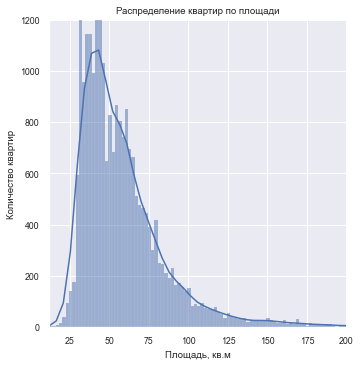

In [37]:
sns.displot(data=df, x='total_area', kde=True)
plt.xlim(df.total_area.min(), 200)
plt.ylim(0, 1200)
plt.title('Распределение квартир по площади')
plt.xlabel('Площадь, кв.м')
plt.ylabel('Количество квартир')
plt.show()

Как мы видим, большинство проданных квартир имеют площадь от 30 до 75 кв.метров. Далее прослеживается тенденция - при увеличении площади недвижимости количество ощутимо падает.

* **Стоимость недвижимости**

Построим график распределения стоимостей недвижимости:

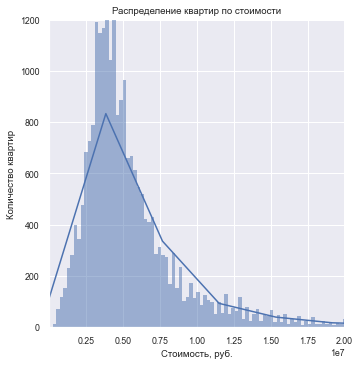

In [38]:
sns.displot(data=df, x='last_price', kde=True)
plt.xlim(df.last_price.min(), 20000000)
plt.ylim(0, 1200)
plt.title('Распределение квартир по стоимости')
plt.xlabel('Стоимость, руб.')
plt.ylabel('Количество квартир')
plt.show()

Здесь мы наблюдаем распределение значений, приближенное к нормальному (Гаусса). Основное количество проданных квартир приходится на интервал от 2.5 млн до 5 млн.

* **Количество комнат**

Построим график распределения количества комнат:

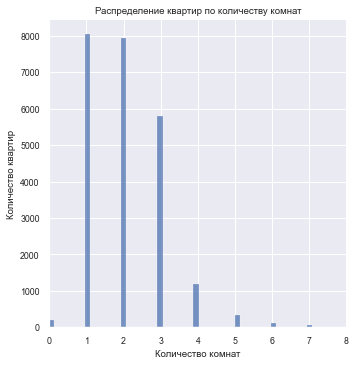

In [39]:
sns.displot(data=df, x='rooms')
plt.xlim(df.rooms.min(), 8)
plt.title('Распределение квартир по количеству комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Количество квартир')
plt.show()

В датасете преобладают квартиры с 1-2 комнатами - их около 8000; трёхкомнатных квартир примерно на четверть меньше. Многокомнатная недвижимость (4 комнаты и более) и квартиры-студии представлены в меньшем количестве (1200 и менее).

* **Высоты потолков**

Поскольку мы ранее уже обращали внимание на аномальные значения в этом столбце, здесь для наглядности примем в качестве границ диапазона значения от 2.3 метров до 4 метров включительно:

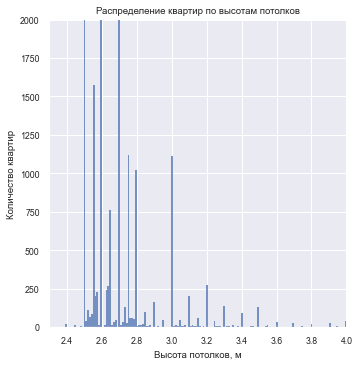

In [40]:
sns.displot(data=df, x='ceiling_height')
plt.xlim(2.3, 4)
plt.ylim(0, 2000)
plt.title('Распределение квартир по высотам потолков')
plt.xlabel('Высота потолков, м')
plt.ylabel('Количество квартир')
plt.show()

Мы наблюдаем, что для подавляющего большинства квартир характерны потолки высотой 2.5-3 метра. Недвижимость с более высокими потолками также имеет место быть.

### Изучение времени продажи квартиры

Перед нами стоит следующий вопрос:

*Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?*

Ранее мы выделили из столбца `first_day_exposition` день недели, месяц и год для каждого объявления. Изучим при помощи графиков эти параметры и рассмотрим, в какие дни, месяцы и годы объявлений больше всего.

* **Дни недели**

Создадим сводную таблицу по дням недели и построим по ней график:

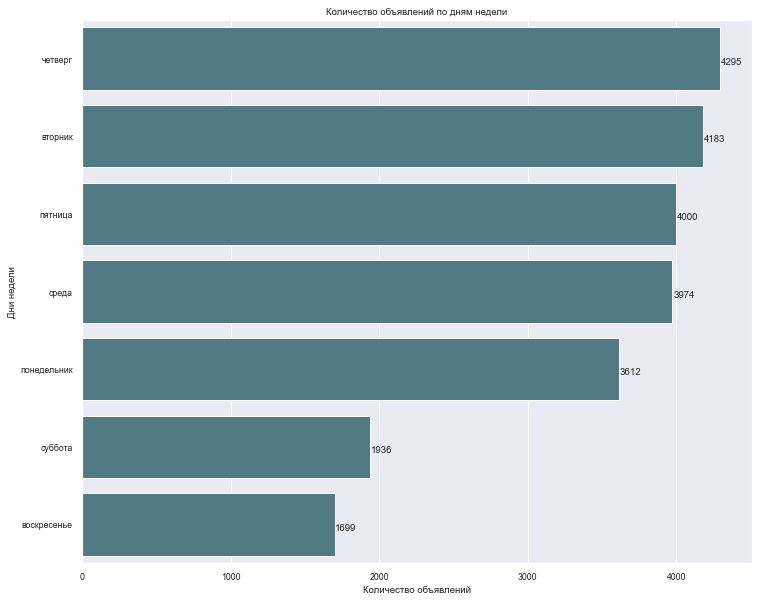

In [41]:
num_listings_by_weekdays = (
    df
    .groupby('weekday')
    .agg({'first_day_exposition': 'count'})
    .reset_index()
    .sort_values(by='first_day_exposition', ascending=False)
)

chart = sns.barplot(x='first_day_exposition', y='weekday', data=num_listings_by_weekdays, color='#4a7f8a')
plt.title('Количество объявлений по дням недели')
plt.xlabel('Количество объявлений')
plt.ylabel('Дни недели')
for p in chart.patches:
    width = p.get_width()
    plt.text(5+p.get_width(), p.get_y()+0.55*p.get_height(),
             '{:1.0f}'.format(width),
             ha='left', va='center')
plt.show()

Здесь мы видим, что большинство объявлений подаётся в четверг, немногим меньше - во вторник, среду и пятницу. Менее всего объявлений регистрируется в выходные.

* **Месяцы**

Создадим сводную таблицу по месяцам и построим по ней график:

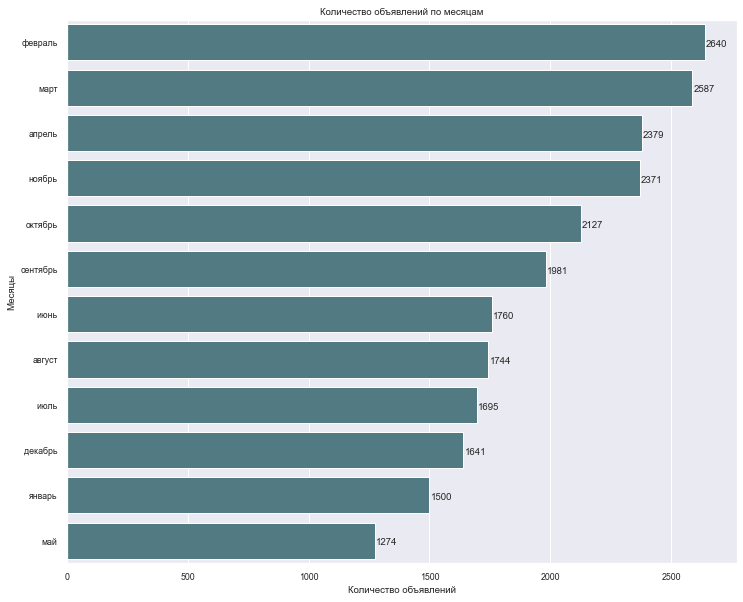

In [42]:
num_listings_by_months = (
    df
    .groupby('month')
    .agg({'first_day_exposition': 'count'})
    .reset_index()
    .sort_values(by='first_day_exposition', ascending=False)
)

chart = sns.barplot(x='first_day_exposition', y='month', data=num_listings_by_months, color='#4a7f8a')
plt.title('Количество объявлений по месяцам')
plt.xlabel('Количество объявлений')
plt.ylabel('Месяцы')
for p in chart.patches:
    width = p.get_width()
    plt.text(5+p.get_width(), p.get_y()+0.55*p.get_height(),
             '{:1.0f}'.format(width),
             ha='left', va='center')
plt.show()

Подавляющее большинство объявлений регистрируются в феврале и марте: когда новогодние праздники позади, а до летнего отпуска ещё далеко, люди чаще прочего задумываются об улучшении жилищных условий. Наименьшее количество объявлений приходится на январь и март, что неудивительно - на эти месяца приходится наибольшее в году количество нерабочих дней.

* **Годы**

Создадим сводную таблицу по годам и построим по ней график:

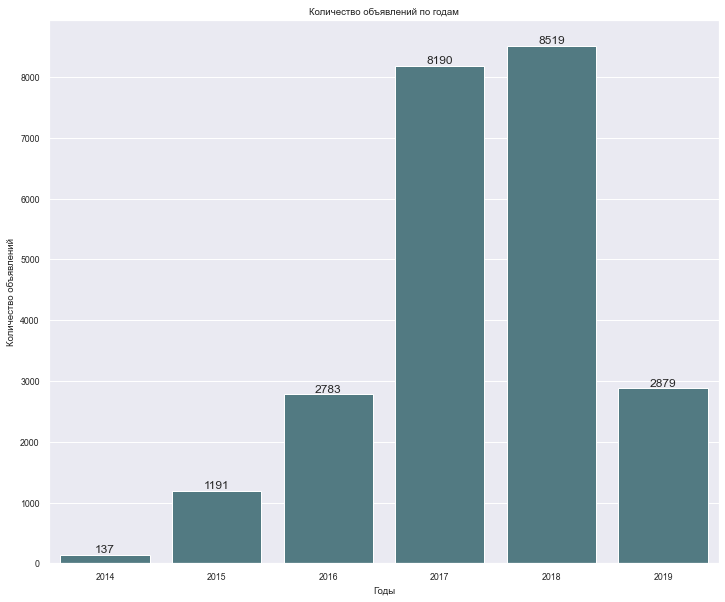

In [43]:
num_listings_by_years = (
    df
    .groupby('year')
    .agg({'first_day_exposition': 'count'})
    .reset_index()
    .sort_values(by='first_day_exposition', ascending=False)
)

chart = sns.barplot(x='year', y='first_day_exposition', data=num_listings_by_years, color='#4a7f8a')
plt.title('Количество объявлений по годам')
plt.xlabel('Годы')
plt.ylabel('Количество объявлений')
for p in chart.patches:
    chart.annotate("%1.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', fontsize=12, xytext=(0, 5),
                   textcoords='offset points')
plt.show()

Здесь же выводы стоит делать не сколько по годам, когда продажи квартир шли хорошо, сколько о работе сервиса "Яндекс Недвижимость". По данным Википедии, с 2014 года сервис перешёл к самостоятельному размещению объявлений, что ознаменовало наблюдаемый по диаграмме рост. Количество объявлений увеличивалось вплоть до 2019 года, после которого резко пошло на спад. Чтобы понять причину данного спада, потребуется изучить, представлены ли данные в датафрейме за весь период 2019 года, либо рассмотреть влияние сторонних факторов.

* **Время продажи квартиры**

Далее рассмотрим столбец `days_exposition`. Сперва запросим по нему описательную статистику:

In [44]:
df.days_exposition.describe().to_frame()

,days_exposition
count,20518.000000
mean,180.888634
std,219.727988
min,1.000000
25%,45.000000
50%,95.000000
75%,232.000000
max,1580.000000


Среднее значение составляет 180 дней (полгода), его явно искажает максимум, равный в пересчете 4.5 годам. Медиана внушает куда больше доверия: она составляет 95 дней (три месяца).

Минимальное время демонстрации объявления составляет 1 день. Это вызывает вопросы: даже если квартира быстро нашла своего покупателя, срок слишком короткий, чтобы по всем правилам оформить сделку. Стоит запросить подробную информацию по этому объявлению: в данных скорее всего ошибка.

Как упоминалось выше, самый длительный по времени показ составляет 4.5 года. Довольно долго, но порой встречаются и такие случаи.

С учётом сводки выше построим гистограмму распределения:

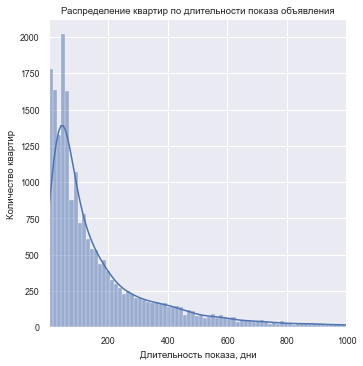

In [45]:
sns.displot(data=df, x='days_exposition', kde=True)
plt.xlim(df.days_exposition.min(), 1000)
plt.title('Распределение квартир по длительности показа объявления')
plt.xlabel('Длительность показа, дни')
plt.ylabel('Количество квартир')
plt.show()

Данные имеют распределение Пуассона, что свойственно для временных величин. Однако мы можем наблюдать аномальные пики. Видоизменим график, чтобы рассмотреть их подробнее:

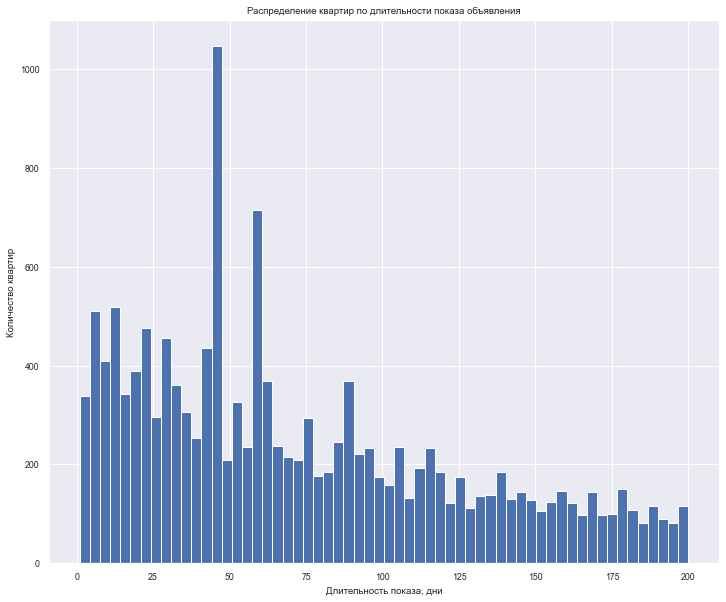

In [46]:
df.days_exposition.hist(range=(df.days_exposition.min(), 200), bins=60)
plt.title('Распределение квартир по длительности показа объявления')
plt.xlabel('Длительность показа, дни')
plt.ylabel('Количество квартир')
plt.show()

Как мы видим, в районе 45 и 60 дней наблюдаются аномальные всплески. Стоит уточнить у отдела разработки, с чем это может быть связано.

### Изучение выбросов и составление достоверного среза данных

Следующее на повестке:

*Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили.*

Изучим на предмет выбросов следующие столбцы:

* `total_area`
* `last_price`
* `rooms`
* `ceiling_height`
* `days_exposition`

Сделать это лучше всего через диаграмму размаха ("ящик с усами"). Нарисуем диаграмму и запросим по ней данные для каждого рассматриваемого параметра.

* **Площадь недвижимости**

Построим диаграмму размаха для `total_area`:

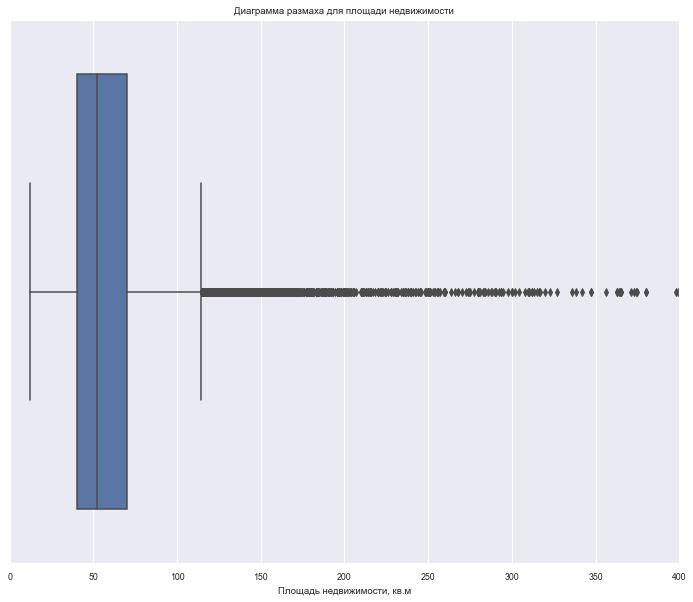

In [47]:
sns.boxplot(data=df, x='total_area')
plt.xlim(0, 400)
plt.title('Диаграмма размаха для площади недвижимости')
plt.xlabel('Площадь недвижимости, кв.м')
plt.show()

Как мы видим, выбросов со стороны правого "уса" (т.е. квартир с большой площадью) очень много и они оказывают влияние на характер распределения значений. Такой тип можно назвать распределением с тяжёлыми хвостами. Т.е. недвижимость большой площади все же имеет значение. Исключив её, мы рискуем сильно обеднить наши данные. Именно по этой причине мы предпочтём не включать данный фактор в наш будущий срез с достоверными данными.

* **Стоимость недвижимости**

Построим диаграмму размаха для `last_price`:

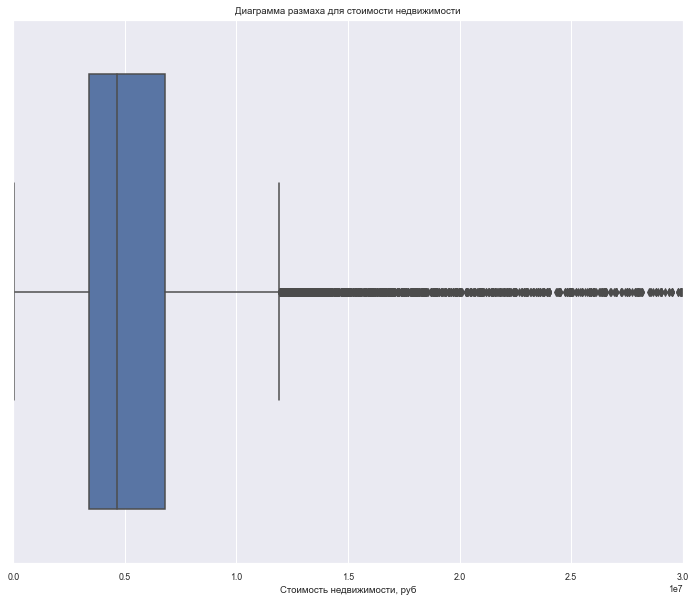

In [48]:
sns.boxplot(data=df, x='last_price')
plt.xlim(0, 30000000)
plt.title('Диаграмма размаха для стоимости недвижимости')
plt.xlabel('Стоимость недвижимости, руб')
plt.show()

Здесь наблюдается огромное число выбросов. Запросим сводку по рассматриваемому столбцу:

In [49]:
df.last_price.describe().to_frame()

,last_price
count,2.369900e+04
mean,6.541549e+06
std,1.088701e+07
min,1.219000e+04
25%,3.400000e+06
50%,4.650000e+06
75%,6.800000e+06
max,7.630000e+08


Вопрос установления границ здесь сложен. С одной стороны, данное распределение также относится распределению с тяжёлыми хвостами, которыми нельзя пренебречь. С другой же - максимальная цена за недвижимость означена как 763 млн, а это приводит наше стандартное отклонение к значению почти 11 млн. Последнее при медиане 4.65 млн абсолютно недопустимо.

По этой причине в текущем исследовании мы примем, что оно не включает в себя элитное жильё, и установим правую границу для `last_price` - **100 000 000**.

* **Количество комнат**

Построим диаграмму размаха для `rooms`:

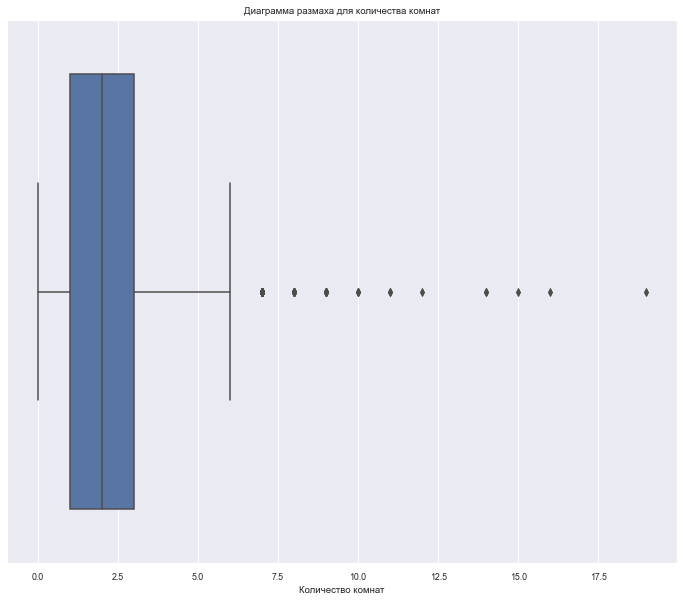

In [50]:
sns.boxplot(data=df, x='rooms')
plt.title('Диаграмма размаха для количества комнат')
plt.xlabel('Количество комнат')
plt.show()

Выбросов здесь значительно меньше, чем в случаях выше. Для того, чтобы не обеднять наши данные, мы также исключим этот фактор из влияния на конечный срез.

* **Высоты потолков**

Построим диаграмму размаха для `ceiling_height`:

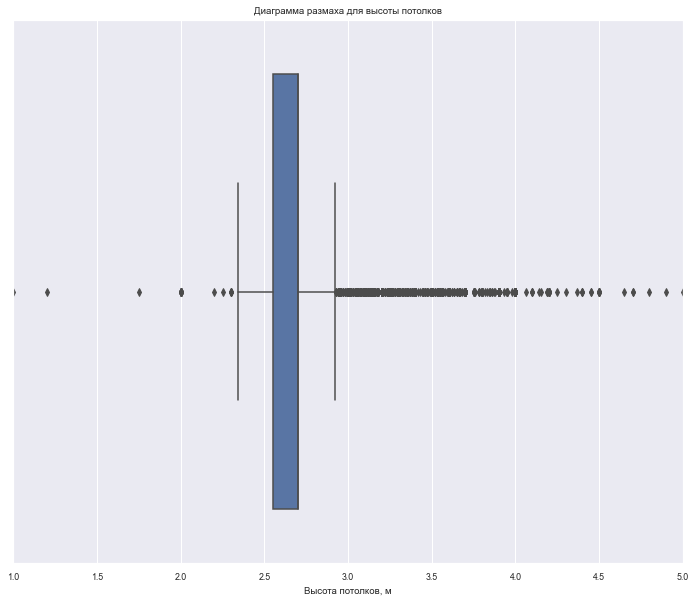

In [51]:
sns.boxplot(data=df, x='ceiling_height')
plt.xlim(df.ceiling_height.min(), 5)
plt.title('Диаграмма размаха для высоты потолков')
plt.xlabel('Высота потолков, м')
plt.show()

Здесь также наблюдается огромное число выбросов, причём с обеих сторон. Запросим данные описательной статистики по столбцу:

In [52]:
df.ceiling_height.describe().to_frame()

,ceiling_height
count,23543.000000
mean,2.734102
std,1.012723
min,1.000000
25%,2.550000
50%,2.700000
75%,2.700000
max,100.000000


У большого количества данных (75%) высота потолков составляет 2.7 метра. Обратим внимание на минимальное и максимальное значение. В данном случае назвать это распределением с тяжёлыми хвостами не выйдет: согласно СНиП, потолки в жилой недвижимости не могут быть ниже 2.3 метров. Также можно допустить, что потолков высотой 100 метров в квартире быть не может.

Опираясь на это, установим левую границу для `ceiling_height` - **2.3**, а правую - **5**.

* **Время продажи**

Построим диаграмму размаха для `days_exposition`:

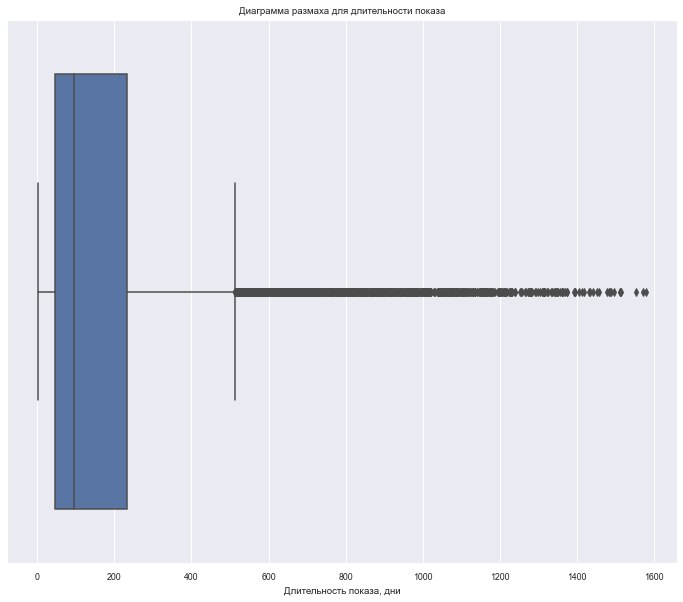

In [53]:
sns.boxplot(data=df, x='days_exposition')
plt.title('Диаграмма размаха для длительности показа')
plt.xlabel('Длительность показа, дни')
plt.show()

Запросим данные описательной статистики по столбцу:

In [54]:
df.days_exposition.describe().to_frame()

,days_exposition
count,20518.000000
mean,180.888634
std,219.727988
min,1.000000
25%,45.000000
50%,95.000000
75%,232.000000
max,1580.000000


Выше уже упоминалось, что минимальное время продажи (1 день) весьма и весьма сомнительно, тогда как максимальное (4.5 года) имеет право на существование.

Установим правую границу для `days_exposition` - **7**.

* **Составление достоверного среза данных и оценка потерь**

Теперь оценим, какое количество потерь в данных будет, если удалить все значения, охарактеризованные выше как выбросы. Для этого запросим срез с данными, обратившись при помощи `query` и задав все границы, и рассчитаем отношение количества его строк к общему.

Чтобы не лишить нашу выборку весомой части данных, все условия будут рассматриваться совместно:

In [55]:
print(f'Потери: {round(1 - len(df.query("last_price < 100000000 and 2.3 < ceiling_height < 5 and days_exposition > 7")) / len(df), 2)*100} %')

Потери: 18.0 %


Потерь оказалось слишком много. При формировании достоверного среза данных мы можем пожертвовать не более чем 10% от всего объема; в противном случае наша выборка будет обеднена.

Рассмотрим, какими условиями можно пожертвовать в данной ситуации:

* `ceiling_height` в жилье квартирного типа физически не может быть больше или меньше указанных выше значений, поэтому этот параметр убирать нельзя;

* `last_price` ввиду того, что ранее мы решили исключить недвижимость класса "люкс", также должен присутствовать;

* `days_exposition` и его границами мы можем поступиться, поскольку предположение об ошибочности данных о раннем снятии квартир с продажи должно быть проверено в отдельном исследовании.

Уберём условие для `days_exposition` и оценим отношение объёма достоверной выборки к общему:

In [56]:
print(f'Потери: {round(1 - len(df.query("last_price < 100000000 and 2.3 < ceiling_height < 5")) / len(df), 2)*100} %')

Потери: 1.0 %


Мы получили примерно 1% отбракованных данных. Это немного, и результат нас устраивает.

Теперь можно создать срез с достоверными данными `good_data`, запросив его при помощи `query` и задав все границы, перечисленные выше:

In [57]:
good_data = df.query('last_price < 100000000 and 2.3 < ceiling_height < 5').reset_index(drop=True)
good_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23447 entries, 0 to 23446
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23447 non-null  int64         
 1   last_price            23447 non-null  float64       
 2   total_area            23447 non-null  float64       
 3   first_day_exposition  23447 non-null  datetime64[ns]
 4   rooms                 23447 non-null  int64         
 5   ceiling_height        23447 non-null  float64       
 6   floors_total          23363 non-null  float64       
 7   living_area           21583 non-null  float64       
 8   floor                 23447 non-null  int64         
 9   is_apartment          23447 non-null  bool          
 10  studio                23447 non-null  bool          
 11  open_plan             23447 non-null  bool          
 12  kitchen_area          21224 non-null  float64       
 13  balcony         

### Факторы влияния на стоимость квартиры

Наш следующий вопрос звучит так:

*Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от квадратного метра, числа комнат, этажа (первого или последнего), удалённости от центра. Также изучите зависимость от даты размещения: дня недели, месяца и года*

В дальнейшем мы будем работать со срезом данных `good_data`, созданным выше. Исходя из него, выясним, как соотносятся вышеназванные характеристики с конечной ценой на квартиру и степень их влияния на неё.

* **Связь цены за квартиру с кв.метром**

Для определения взаимосвязи построим *hexbin*-график:

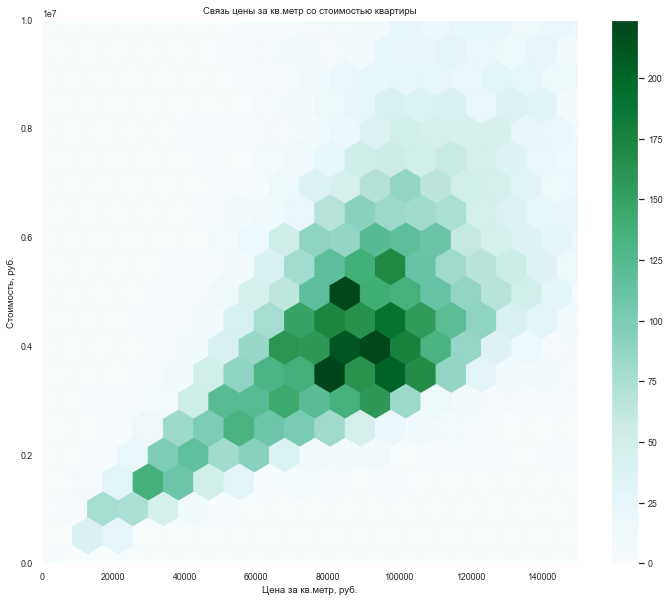

In [58]:
(
    good_data
    .pivot_table(index='sqmeter_cost', values='last_price', aggfunc = 'median')
    .reset_index()
    .plot(x='sqmeter_cost', y='last_price', xlim=(0, 150000), ylim=(0, 10000000), gridsize=(100,100), kind='hexbin', sharex=False, grid=True)
)
plt.title('Связь цены за кв.метр со стоимостью квартиры')
plt.xlabel('Цена за кв.метр, руб.')
plt.ylabel('Стоимость, руб.')
plt.show()

Здесь прослеживается повышение частоты встречания определённой цены за квадратный метр (80 тыс. и 100 тыс.) с конечной ценой в 3.5 млн.

Выведем на экран коэффициент корреляции Пирсона:

In [59]:
print(f'Alpha: {round(good_data.last_price.corr(good_data.sqmeter_cost), 2)}')

Alpha: 0.71


Значение коэффициента равно 0.71, то есть присутствует сильная линейная взаимосвязь: с повышением цены за кв.метр растет и конечная стоимость недвижимости. С другой стороны, оно и неудивительно: цена за кв.метр вычислена искусственно из стоимости за квартиру, поэтому в полной мере верить этой взаимосвязи нельзя.

* **Связь цены за квартиру с количеством комнат**

Для выяснения связи этого параметра построим линейный график:

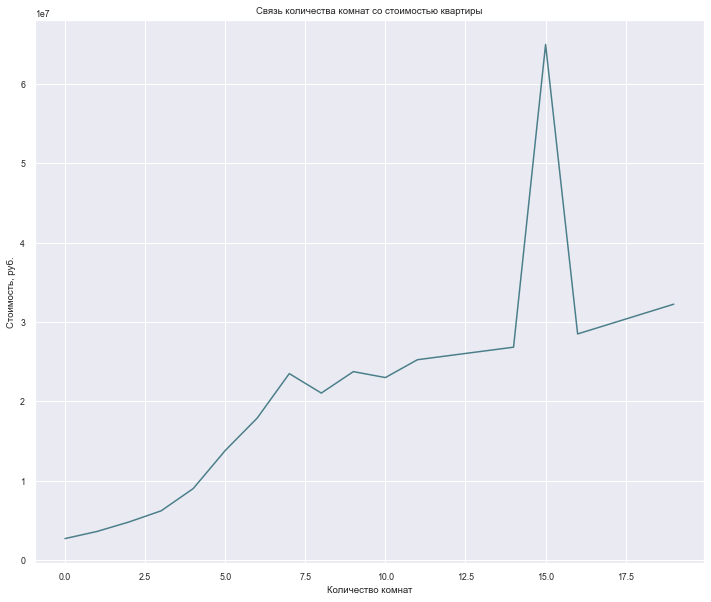

In [60]:
rooms_and_price = (
    good_data
    .groupby('rooms')
    .agg({'last_price': 'median'})
    .reset_index()
)

sns.lineplot(data=rooms_and_price, x='rooms', y='last_price', color='#4a7f8a')
plt.title('Связь количества комнат со стоимостью квартиры')
plt.xlabel('Количество комнат')
plt.ylabel('Стоимость, руб.')
plt.show()

Выше можно наблюдать, что с увеличением количества комнат цена за квартиру растёт по экспоненте, однако по достижении 7 комнат тенденция не продолжается. Также отметим аномальный пик, соответствующий 15 комнатам. Можно допустить, что квартир с таким количеством квартир немного, что сильно искажает нашу медиану.

Выведем на экран коэффициент корреляции Пирсона:

In [61]:
print(f'Alpha: {round(good_data.last_price.corr(good_data.rooms), 2)}')

Alpha: 0.47


Итак, влияние количество комнат на конечную стоимость неоспоримо, но тем не менее не настолько весомо, чтобы однозначно определять её формирование: в выборке могут присутствовать бывшие общежития с большим количеством комнат, стоимость которых несравнима со стоимостью многокомнатных квартир.

* **Связь цены за квартиру с этажом (первый, последний)**

В этом случае удобнее будет построить столбчатую диаграмму:

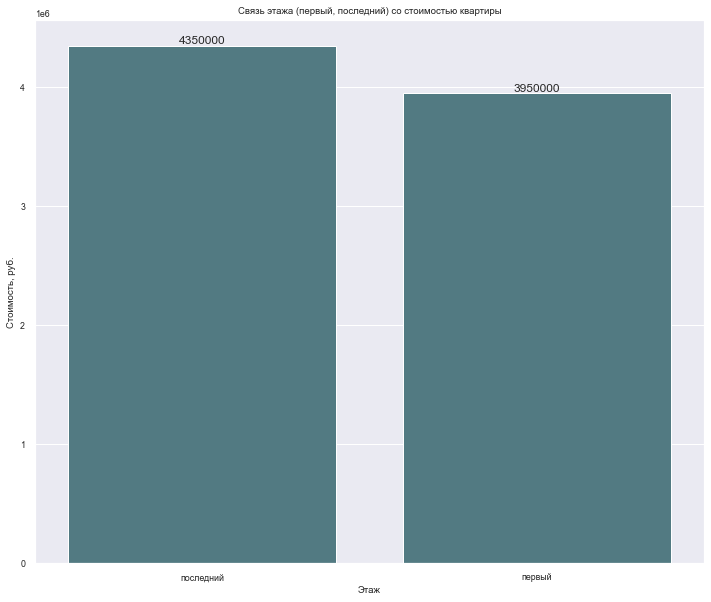

In [62]:
group_floor_and_price = (
    good_data
    .query('group_floor != "другой"')
    .groupby('group_floor')
    .agg({'last_price': 'median'})
    .reset_index()
    .sort_values(by='last_price', ascending=False)
)

chart = sns.barplot(x='group_floor', y='last_price', data=group_floor_and_price, color='#4a7f8a')
plt.title('Связь этажа (первый, последний) со стоимостью квартиры')
plt.xlabel('Этаж')
plt.ylabel('Стоимость, руб.')
for p in chart.patches:
    chart.annotate("%1.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', fontsize=12, xytext=(0, 5),
                   textcoords='offset points')
plt.show()

Как видно выше, квартиры на первых этажах в среднем на 20% дешевле, чем на последних (чем красивее вид из окна, тем дороже квартира).

* **Связь цены за квартиру с удалённостью от центра**

Построим диаграмму рассеяния:

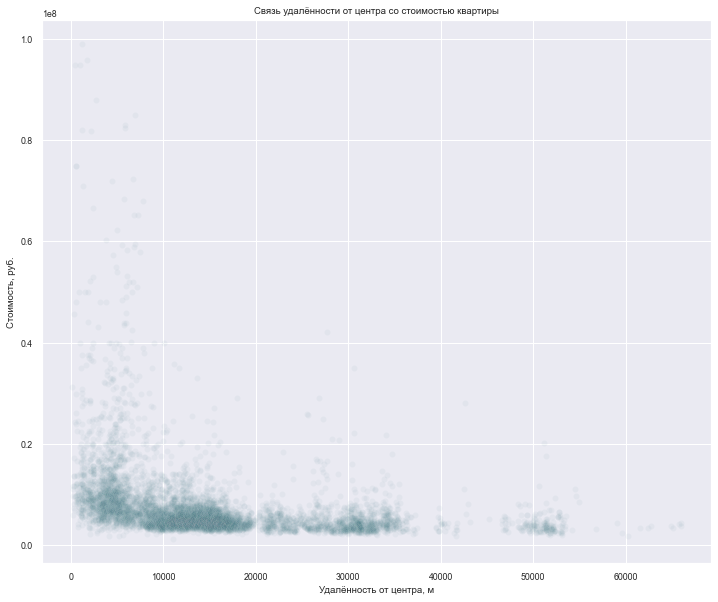

In [63]:
city_center_and_price = (
    good_data
    .groupby('city_centers_nearest')
    .agg({'last_price': 'median'})
    .reset_index()
)

sns.scatterplot(x='city_centers_nearest', y='last_price', data=city_center_and_price, color='#4a7f8a', alpha=0.05)
plt.title('Связь удалённости от центра со стоимостью квартиры')
plt.xlabel('Удалённость от центра, м')
plt.ylabel('Стоимость, руб.')
plt.show()

Исходя из картины выше можно судить, что:
* самые дорогие квартиры приходятся на центр города
* наибольшее количество продаваемых квартир приходятся на диапазон от 10 км до 20 км удалённости от центра.

Проверим коэффициент Пирсона для данного параметра:

In [64]:
print(f'Alpha: {round(good_data.last_price.corr(good_data.city_centers_nearest), 2)}')

Alpha: -0.3


Как мы видим, присутствует некоторая отрицательная взаимосвязь, но она нелинейна, и не может однозначно определять конечную стоимость.

* **Связь цены за квартиру с днём недели**

Построим столбчатую диаграмму:

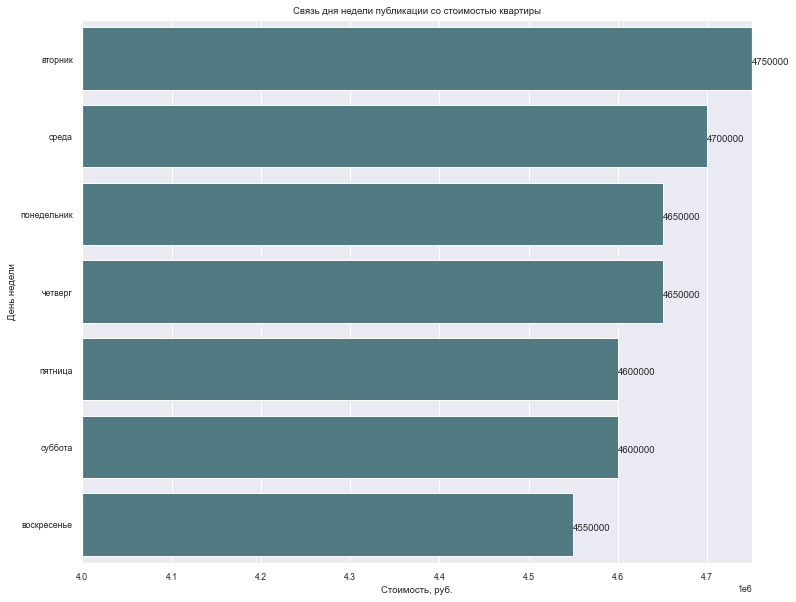

In [65]:
weekday_and_price = (
    good_data
    .groupby('weekday')
    .agg({'last_price': 'median'})
    .sort_values(by='last_price', ascending=False)
    .reset_index()
)

chart = sns.barplot(data=weekday_and_price, x='last_price', y='weekday', color='#4a7f8a')
plt.xlim(4000000, weekday_and_price.last_price.max())
plt.title('Связь дня недели публикации со стоимостью квартиры')
plt.xlabel('Стоимость, руб.')
plt.ylabel('День недели')
for p in chart.patches:
    width = p.get_width()
    plt.text(5+p.get_width(), p.get_y()+0.55*p.get_height(),
             '{:1.0f}'.format(width),
             ha='left', va='center')
plt.show()

Крайне занятная особенность: по графику можно решить, что самые дорогие квартиры выставляются по вторникам, а самые дешёвые - по пятницам и на выходных. Лучше уточнить у отдела разработки, с чем это может быть связано.

* **Связь цены за квартиру с месяцем**

Построим столбчатую диаграмму:

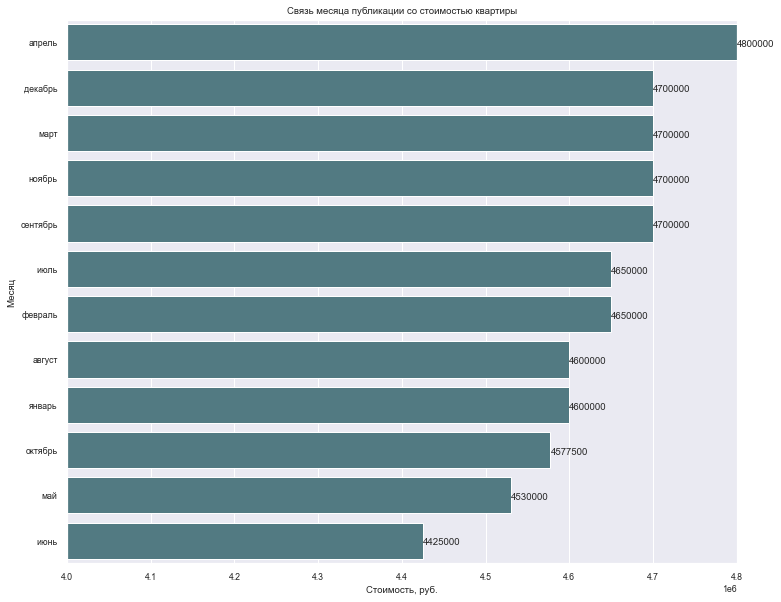

In [66]:
month_and_price = (
    good_data
    .groupby('month')
    .agg({'last_price': 'median'})
    .sort_values(by='last_price', ascending=False)
    .reset_index()
)

chart = sns.barplot(data=month_and_price, x='last_price', y='month', color='#4a7f8a')
plt.xlim(4000000, month_and_price.last_price.max())
plt.title('Связь месяца публикации со стоимостью квартиры')
plt.xlabel('Стоимость, руб.')
plt.ylabel('Месяц')
for p in chart.patches:
    width = p.get_width()
    plt.text(5+p.get_width(), p.get_y()+0.55*p.get_height(),
             '{:1.0f}'.format(width),
             ha='left', va='center')
plt.show()

По графику выше можно сказать, что:
* самая высокая стоимость жилья регистрируется в апреле;
* самая низкая - в июне.

На последнее, вероятно, влияет начало сезона отпусков.

* **Связь цены за квартиру с годом**

Построим линейный график:

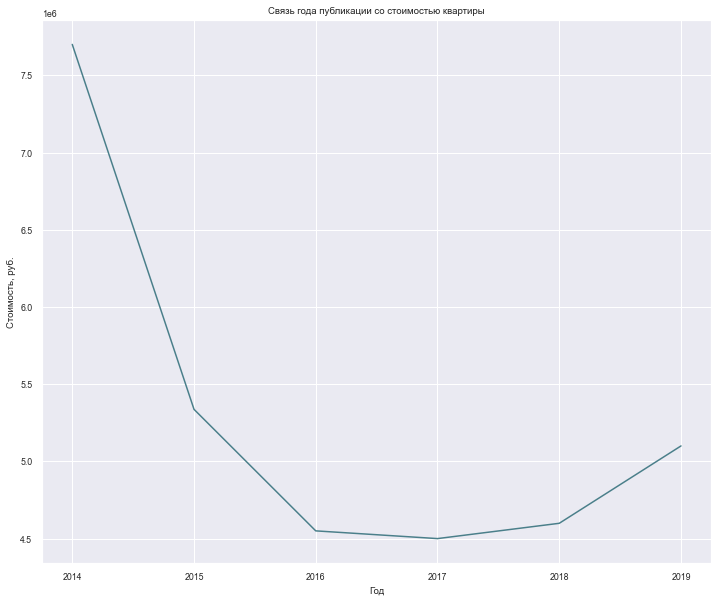

In [67]:
year_and_price = (
    good_data
    .groupby('year')
    .agg({'last_price': 'median'})
    .reset_index()
)

sns.lineplot(data=year_and_price, x='year', y='last_price', color='#4a7f8a')
plt.title('Связь года публикации со стоимостью квартиры')
plt.xlabel('Год')
plt.ylabel('Стоимость, руб.')
plt.show()

Наивысшая медианная стоимость недвижимости приходится на 2014 год. Далее начинается спад, затем - небольшое повышение, начиная с 2019 года.

### Самые популярные населённые пункты

Следующее, что мы рассмотрим:

*Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце `locality_name`*

Для этого поочерёдно выполним следующее:
* сгруппируем данные по `locality_name` и рассчитаем количество объявлений и среднюю стоимость кв.метра, результат сохраним в таблицу `top_10`
* уберём мульти-индекс из названий столбцов новой таблицы их путём переименования
* отсортируем таблицу `top_10` по убыванию количества объявлений, выберем 10 первых населённых пунктов и пересохраним результат обратно в `top_10`

In [68]:
top_10 = (
    good_data
    .pivot_table(index = 'locality_name', values = 'sqmeter_cost', aggfunc=['count', 'mean'])
    .reset_index()
)
top_10.columns = ['locality_name','count', 'mean_sqm_cost']
top_10 = top_10.sort_values('count', ascending = False).head(10)
display(top_10)

,locality_name,count,mean_sqm_cost
33,Санкт-Петербург,15657,113560.376117
227,посёлок Мурино,520,85725.241346
253,посёлок Шушары,440,78677.364318
3,Всеволожск,397,68719.320378
32,Пушкин,369,103125.819377
13,Колпино,338,75424.579112
230,посёлок Парголово,327,90175.913089
6,Гатчина,306,68757.678399
87,деревня Кудрово,299,92473.547559
4,Выборг,235,58238.143277


Из данной выборки десяти наиболее популярных населённых пунктов видно, что самое дорогое жильё находится в Санкт-Петербурге и Пушкине, а самое дешёвое - в Выборге.

Выведем описательную статистику для цены за кв. метр сводной таблицы `top_10`:

In [69]:
top_10.mean_sqm_cost.describe().to_frame()

,mean_sqm_cost
count,10.000000
mean,83487.798297
std,16935.425589
min,58238.143277
25%,70424.403577
50%,82201.302832
75%,91899.138941
max,113560.376117


В большинстве населённых пунктов стоимость жилья колеблется в пределах от 70 до 92 тыс. за кв.метр. Медианное значение цены составляет 82 тыс. за кв. метр. Это на 33,5 тыс. выше цены за кв. метр в Санкт-Петербурге (самый дорогой и популярный город) - и почти на 22 тыс. ниже, чем в Выборге (самый дешёвый и наименее популярный город выборки). 

Напрашивается вывод: высокая цена на недвижимость напрямую связана с количеством проживающих в населённом пункте людей и, как следствие, его популярностью.

Теперь посмотрим на распределение значений цены за кв.метр `sqmeter_cost` по этим населённым пунктам. Для этого выполним следующее:
* из достоверного среза данных `good_data` запросим все города, указанные в индексах `top_10`;
* по этим данным построим диаграммы "ящик с усами" для `sqmeter_cost` по каждому из городов.

Для более визуального сравнения отобразим все диаграммы на одной плоскости:

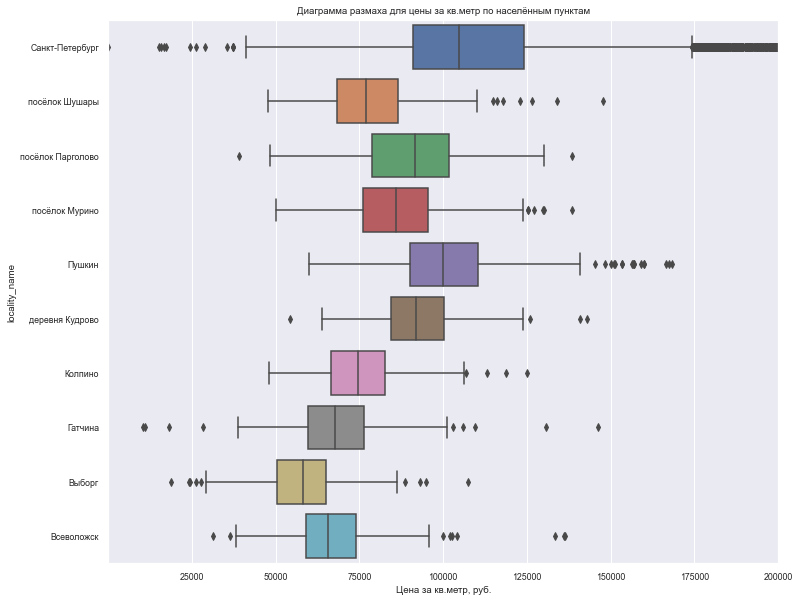

In [70]:
top_10_sqm_cost = (good_data.query('locality_name in @top_10.locality_name'))

sns.boxplot(data=top_10_sqm_cost, x='sqmeter_cost', y='locality_name')
plt.xlim(top_10_sqm_cost.sqmeter_cost.min(), 200000)
plt.title('Диаграмма размаха для цены за кв.метр по населённым пунктам')
plt.xlabel('Цена за кв.метр, руб.')
plt.show()

Выше мы можем наблюдать сразу несколько особенностей:
* колебание медианной цены за кв.метр площади (в Санкт-Петербурге она наивысшая, как мы уже отмечали ранее);
* различная ширина размаха допустимых значений (в Санкт-Петербурге она несравнимо больше, чем в других населённых пунктах);
* наличие выбросов и их количество (в Санкт-Петербурге, опять же, очень много дорогого жилья).

Исходя из этого, имеет смысл рассматривать Санкт-Петербург отдельно от всех остальных городов, что мы в дальнейшем и сделаем.

### Зависимость цены от удалённости от центра (Санкт-Петербург)

Теперь рассмотрим следующее:

*Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге (`locality_name`). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона*

Выполним требуемые действия:

In [71]:
#выделим срез данных по Санкт-Петербургу
spb_data = good_data.query('locality_name == "Санкт-Петербург"')

#обойдем предупреждение SettingWithCopyWarning
spb_data = spb_data.copy()

#создадим столбец с расстоянием от центра
spb_data['city_center_km'] = round(spb_data.loc[:, 'city_centers_nearest'] / 1000, 0)

display(spb_data.head())

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,sqmeter_cost,weekday,month,year,group_floor,living_ratio,kitchen_ratio,city_center_km
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370.37,четверг,март,2019,другой,0.47,0.23,16.0
2,10,5196000.0,56.0,2015-08-20,2,2.70,5.0,34.3,4,False,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785.71,четверг,август,2015,другой,0.61,0.15,14.0
3,0,64900000.0,159.0,2015-07-24,3,2.70,14.0,NaN,9,False,False,False,NaN,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,408176.10,пятница,июль,2015,другой,NaN,NaN,7.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,False,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000.00,вторник,июнь,2018,другой,0.32,0.41,8.0
7,5,7915000.0,71.6,2019-04-18,2,2.70,24.0,NaN,22,False,False,False,18.9,2,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN,110544.69,четверг,апрель,2019,другой,NaN,0.26,12.0


Построим график:

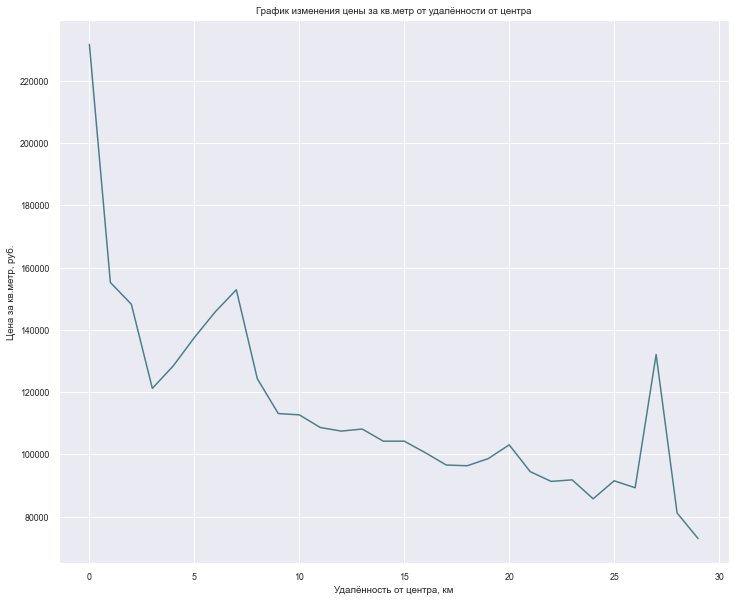

In [72]:
mean_price_per_km = (spb_data.groupby('city_center_km').agg({'sqmeter_cost': 'mean'}).reset_index())

sns.lineplot(data=mean_price_per_km, x='city_center_km', y='sqmeter_cost', color='#4a7f8a')
plt.title('График изменения цены за кв.метр от удалённости от центра')
plt.xlabel('Удалённость от центра, км')
plt.ylabel('Цена за кв.метр, руб.')
plt.show()

По графику выше мы видим, что падение цены за кв.метр начинается в районе 7 км удалённости от центра города. Можно считать, это значение и является границей центральной зоны.

Однако, и в районе центра есть области с низкой стоимостью жилья - вероятно, это старые дома и бывшие коммунальные квартиры.

В районе 27 км от центра Санкт-Петербурга наблюдается резкий пик цены за кв. метр площади - по всей видимости, это районы с недавней застройкой элит-класса.

### Сравнение центральной зоны Санкт-Петербурга со всей выборкой

И, наконец, последний пункт нашего исследования:

*Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всей базе?*

Для начала выделим из датафрейма `spb_data` центральную зону (в пределах удалённости 7 км от центра) и запросим по ее параметрам (`total_area`, `last_price`, `rooms`, `ceiling_height`) сводную информацию:

In [73]:
center_data = spb_data.query('city_center_km <= 7')
center_data[['total_area', 'last_price', 'rooms', 'ceiling_height']].describe()

,total_area,last_price,rooms,ceiling_height
count,3483.000000,3.483000e+03,3483.000000,3483.000000
mean,90.865507,1.313732e+07,2.813379,2.948361
std,53.794770,1.230685e+07,1.432243,0.337238
min,12.000000,1.600000e+06,0.000000,2.400000
25%,56.700000,6.650000e+06,2.000000,2.700000
50%,78.000000,9.100000e+06,3.000000,2.800000
75%,108.950000,1.400000e+07,3.000000,3.120000
max,590.000000,9.900000e+07,19.000000,4.800000


Можем заметить следующее:

* *площадь недвижимости*

    Общие площади недвижимости представлены в диапазоне от 12 кв. метров до 590 кв. метров. Медианное значение площади составляет 76 кв. метров, что равносильно трёхкомнатной квартире.
    
    
* *цены*

    Стоимость квартир колеблется от 1.68 млн и до 99 млн включительно. Медианная цена на недвижимость - 8.77 млн.
    

* *количество комнат*

    Минимальное количество комнат - 0 (квартиры-студии), максимальное - 19. Можно допустить, что последние отражают недвижимость нежилого фонда либо общежития. Медианное значение по количеству комнат - 3.
    
    
* *высоты потолков*

    Высоты потолков находятся в диапазоне от 2.4 метра до 4.8 метров включительно. Медиана высоты потолков - 2.75 метра.
    
Мы уже можем наблюдать отличия от анализа по всему объёму выборки, который рассматривался в **пункте 4.1**.

Взглянем поближе на характер распределения параметров. Ниже будут выведены попарно две гистограммы:
* синего цвета - для всей выборки данных,
* оранжевого цвета - для центра Санкт-Петербурга

* **Площадь недвижимости**

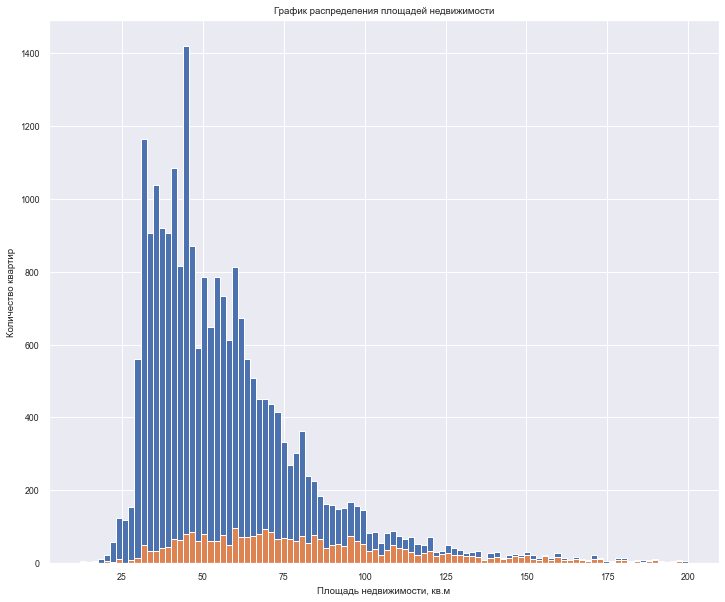

In [74]:
good_data.total_area.hist(range=(df.total_area.min(), 200), bins=100)
center_data.total_area.hist(range=(df.total_area.min(), 200), bins=100)
plt.title('График распределения площадей недвижимости')
plt.xlabel('Площадь недвижимости, кв.м')
plt.ylabel('Количество квартир')
plt.show()

Распределения по площадям похожи друг на друга - с той лишь разницей, что на центр Санкт-Петербурга приходится меньшее количество объявлений. Кроме того, в центре количество квартир с площадью до 75 кв. метров не намного превышает количество квартир большей площади (75-130 кв. метров) - в отличие от показателей основной выборки, где различие более заметно.

* **Стоимость недвижимости**

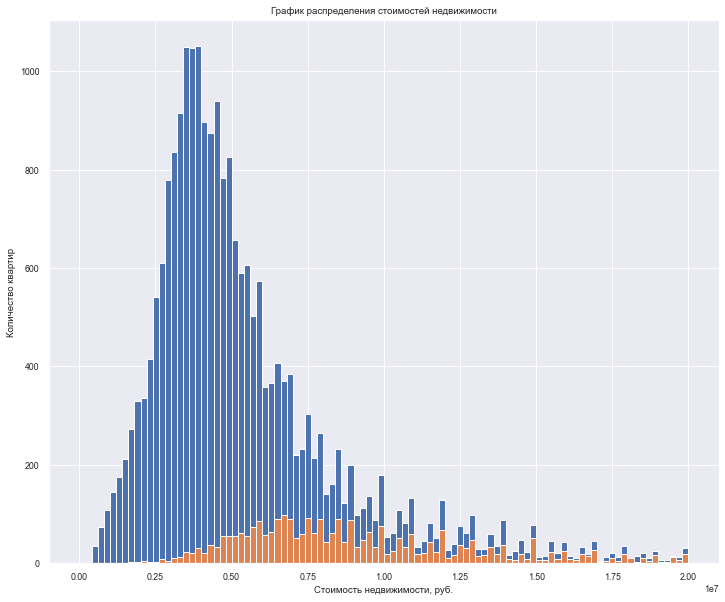

In [75]:
good_data.last_price.hist(range=(df.last_price.min(), 20000000), bins=100)
center_data.last_price.hist(range=(df.last_price.min(), 20000000), bins=100)
plt.title('График распределения стоимостей недвижимости')
plt.xlabel('Стоимость недвижимости, руб.')
plt.ylabel('Количество квартир')
plt.show()

В случае стоимостей недвижимости центр Санкт-Петербурга более равномерный, чем основная выборка - резкие пики в гистограмме отсутствуют. Также график подтверждает отличие медианной цены за жильё в центре города от той же стоимости по всему городу и окрестностям.

* **Количество комнат**

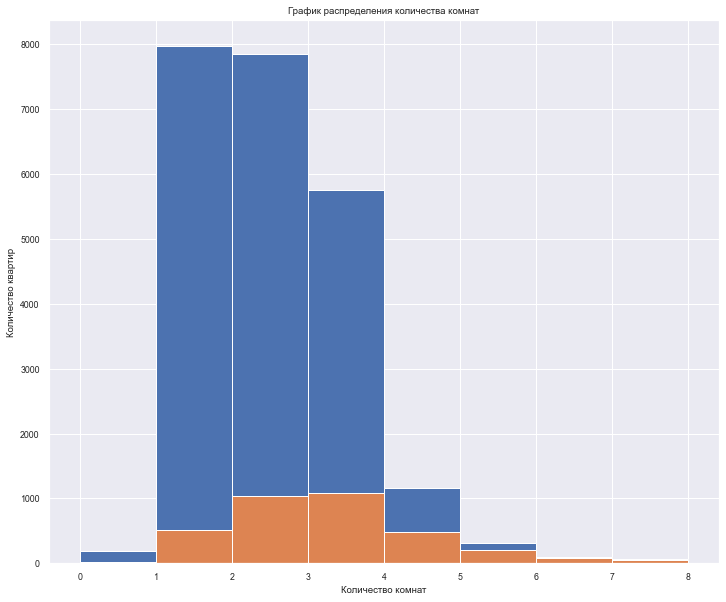

In [76]:
good_data.rooms.hist(range=(df.rooms.min(), 8), bins=8)
center_data.rooms.hist(range=(df.rooms.min(), 8), bins=8)
plt.title('График распределения количества комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Количество квартир')
plt.show()

В обоих случаях распределения по количеству комнат практически повторяют друг друга - опять же, с поправкой, что на центр Санкт-Петербурга приходится меньшее количество объявлений. Кроме того, в Санкт-Петербурге отмечено наличие многокомнатных квартир (7 комнат и более).

* **Высоты потолков**

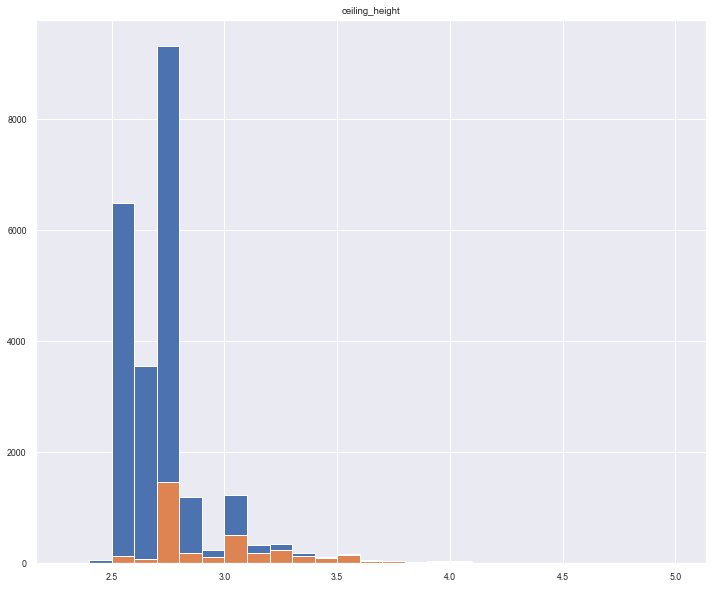

In [77]:
good_data.ceiling_height.hist(range=(2.3, 5), bins=27)
center_data.ceiling_height.hist(range=(2.3, 5), bins=27)
plt.title('ceiling_height')
plt.show()

Из графика выше видно, что в центре Санкт-Петербурга преобладает недвижимость с высокими потолками (от 2.7 и 3.1 метра). Это может быть связано с тем, что там располагаются дома старой застройки. В остальном же распределения практически повторяют друг друга - опять же, с учётом меньшего числа объявлений в центре города.

* **Факторы влияния на стоимость квартиры в центре (число комнат, этаж, удалённость от центра, дата размещения объявления)**

Для определения взаимосвязи с количественными параметрами (число комнат, этаж, удалённость от центра) выведем на экран значения коэффициентов корреляции Пирсона:

In [78]:
center_data[['rooms', 'floor', 'city_centers_nearest', 'last_price']].corr()[['last_price']]

,last_price
rooms,0.400820
floor,0.141106
city_centers_nearest,-0.039929
last_price,1.000000


Мы можем наблюдать лишь условное влияние количества комнат на стоимость квартиры в центре Санкт-Петербурга; впрочем, даже оно не определяет в полной мере конечную стоимость жилья. Вероятно, влияют и иные факторы в совокупности. К примеру, много комнат может быть как у недвижимости элитного класса, так и у бывших общежитий/коммунальных квартир.

Далее рассмотрим влияние дня недели, месяца и года продажи на цену недвижимости в центре Санкт-Петербурга.

* *Связь цены за квартиру в центре с днём недели*

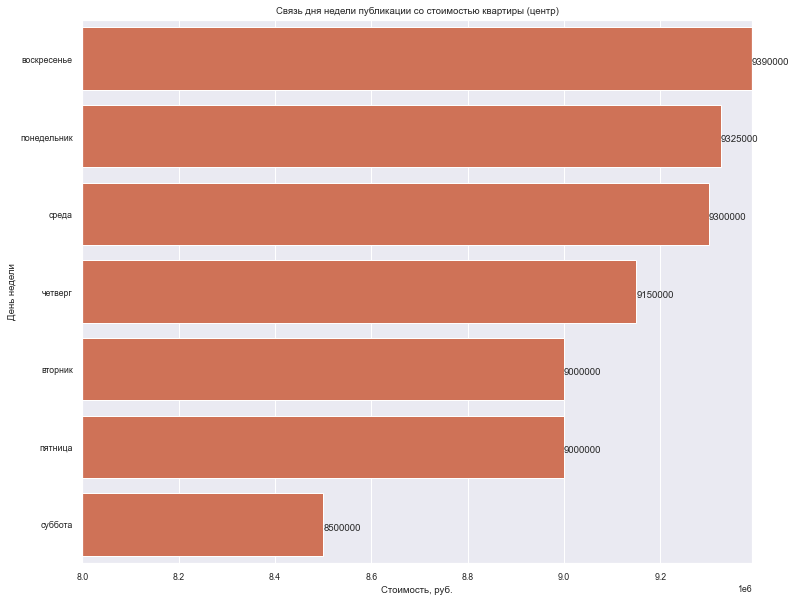

In [79]:
weekday_and_price_center = (
    center_data
    .groupby('weekday')
    .agg({'last_price': 'median'})
    .sort_values(by='last_price', ascending=False)
    .reset_index()
)

chart = sns.barplot(data=weekday_and_price_center, x='last_price', y='weekday', color='#e36743')
plt.xlim(8000000, weekday_and_price_center.last_price.max())
plt.title('Связь дня недели публикации со стоимостью квартиры (центр)')
plt.xlabel('Стоимость, руб.')
plt.ylabel('День недели')
for p in chart.patches:
    width = p.get_width()
    plt.text(5+p.get_width(), p.get_y()+0.55*p.get_height(),
             '{:1.0f}'.format(width),
             ha='left', va='center')
plt.show()

Очень интересная зависимость - стоимость квартиры в субботу и в воскресенье отличается примерно на 1 млн. Однозначно сказать, чем это может быть вызвано, довольно затруднительно. Лучше запросить уточнения у отдела разработки.

* *Связь цены за квартиру в центре с месяцем*

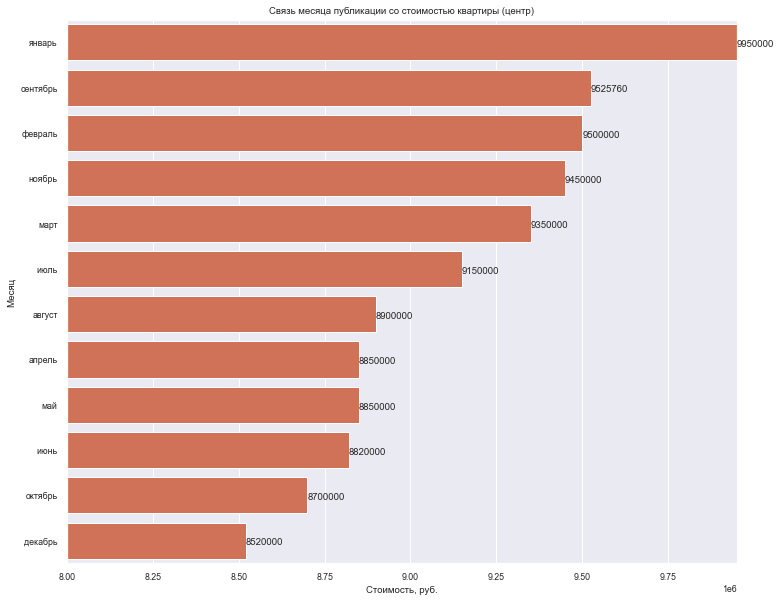

In [80]:
month_and_price_center = (
    center_data
    .groupby('month')
    .agg({'last_price': 'median'})
    .sort_values(by='last_price', ascending=False)
    .reset_index()
)

chart = sns.barplot(data=month_and_price_center, x='last_price', y='month', color='#e36743')
plt.xlim(8000000, month_and_price_center.last_price.max())
plt.title('Связь месяца публикации со стоимостью квартиры (центр)')
plt.xlabel('Стоимость, руб.')
plt.ylabel('Месяц')
for p in chart.patches:
    width = p.get_width()
    plt.text(5+p.get_width(), p.get_y()+0.55*p.get_height(),
             '{:1.0f}'.format(width),
             ha='left', va='center')
plt.show()

Самые дорогие (примерно 10 млн) продажи квартир в центре Санкт-Петербурга приходятся на январь, самые дешёвые (около 8.5 млн) - на декабрь.

* *Связь цены за квартиру в центре с годом*

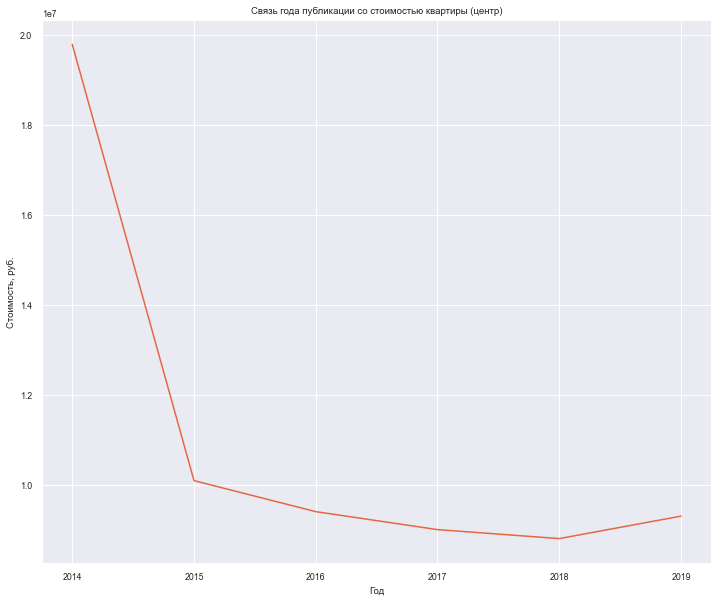

In [81]:
year_and_price_center = (
    center_data
    .groupby('year')
    .agg({'last_price': 'median'})
    .reset_index()
)

sns.lineplot(data=year_and_price_center, x='year', y='last_price', color='#e36743')
plt.title('Связь года публикации со стоимостью квартиры (центр)')
plt.xlabel('Год')
plt.ylabel('Стоимость, руб.')
plt.show()

Здесь наблюдается та же тенденция, что была в общей выборке: резкое падение стоимости жилья, начиная с 2014 г. Только график куда менее плавный, а медианная цена за 2014 год составляет почти 20 млн (против 7.3 млн по общей выборке).

## Общий вывод

Мы провели масштабное исследование недвижимости Санкт-Петербурга и его окрестностей. Был изучен датафрейм на неполные 24 тыс. наблюдений, содержащий 22 различные характеристики жилой недвижимости.

Исследование велось в несколько этапов:

1. ***Предобработка данных***

* Заголовок `cityCenters_nearest` был приведён к стандартному виду.

* Типы данных были приведены к привычному (в случае с `balcony`) или удобному для анализа виду (`first_day_exposition`).
    
* Пропуски были изучены, оценены и в случаях, где они носили случайный характер, а информация предоставлялась авторами объявлений (`ceiling_height`, `is_apartment`, `balcony`) - заменены. 
    
  Картографические данные (`airports_nearest`, `parks_around3000`, `parks_nearest`, `ponds_around3000`, `ponds_nearest`) ввиду большого количества пропущенных значений и невозможности их замены из дальнейшего исследования пришлось исключить.

  Во всех остальных случаях, для сохранения правдоподобности данных, пропущенные значения были оставлены без изменения.


2. ***Расчёты и добавление результатов в таблицу***

   Были посчитаны и добавлены в таблицу:

    * цена квадратного метра;
    * день недели, месяц и год публикации объявления;
    * этаж квартиры (варианты — первый, последний, другой);
    * соотношение жилой и общей площади, а также отношение площади кухни к общей.
    
   Все характеристики, кроме соотношений площадей, принимали непосредственное участие в дальнейшем исследовательском анализе данных.


3. ***Исследовательский анализ данных***

* **Изучение площади, цены, числа комнат, высоты потолков**   
    
  Исследование показало, что большинство проданных квартир имеют площадь до 75 метров, стоимость от 2.5 млн до 5 млн, количество комнат от 2 до 4 и потолки высотой 2.7 метра.  Наиболее типичной недвижимостью на продажу в Санкт-Петербурге и Ленинградской области является двухкомнатная квартира площадью 52 кв. метра, ценой 4.65 млн и потолками высотой 2.7 метра. 
  

* **Изучение времени продажи квартир**
    
  Медианное время продажи составляет три месяца. Самые необычные по длительности продажи - один день (самая быстрая) и 4.5 года (самая долгая). 
       
  Наибольшее количество заявок подаётся в четверг, немногим меньше - во вторник, среду и пятницу. Менее всего объявлений регистрируется в выходные. В разбивке по месяцам всех объявлений приходится на февраль, март, сентябрь, октябрь и ноябрь.
       
  Для сервиса "Яндекс Недвижимость" самыми продуктивными годами были 2017 и 2018 гг.
   
   
* **Изучение выбросов и составление достоверного среза данных**
    
  Выбросы изучались в столбцах:

    * `total_area`
    * `last_price`
    * `rooms`
    * `ceiling_height`
    * `days_exposition`
       
  Были оценены потери данных при фильтрации и по границам параметров `last_price` и `ceiling_height` подготовлен достоверный срез данных. Отфильтрованные значения составили порядка 1% от всего объёма датасета.
     
     
* **Факторы влияния на стоимость квартиры**
     
  Было выявлено, что на высокую стоимость квартиры влияют большое количество комнат, последний этаж и приближенность к центру города. Однако, все эти связи нелинейны и не могут однозначно определять стоимость - влияет непосредственно совокупность факторов.
       
  По временным характеристикам можно отметить, что наивысшая средняя стоимость жилья приходится на вторник, а самая низкая - на воскресенье; квартиры высокой средней стоимостю регистрируются в апреле, а с низкой - в июне; самым дорогим с точки зрения цен на квартиры был 2014 год.
       
       
* **Самые популярные населённые пункты**
    
  Был составлен список 10 населённых пунктов с наибольшим числом объявлений, возглавил который Санкт-Петербург, а замкнул Выборг. В этих населённых пунктах стоимость жилья колеблется в пределах от 70 до 92 тыс. за кв.метр. Медианное значение цены составляет примерно 83 тыс. за кв. метр. Это на 33,5 тыс. выше цены за кв. метр в Санкт-Петербурге (самый дорогой и популярный город) - и почти на 22 тыс. ниже, чем в Выборге (самый дешёвый и наименее популярный город выборки).

  Можно сказать, что популярность города и количество проживающих в нём людей является ещё одним фактором, определяющим стоимость недвижимости.
  
  
* **Зависимость цены от удалённости от центра (Санкт-Петербург)**
    
  По соответствующему графику было определено, что граница центральной зоны Санкт-Петербурга - 7 км удалённости от центра города. Именно там цена за недвижимость демонстрирует резкое падение.

  Также было замечено, что в районе 27 км от центра наблюдается резкий пик цены за кв. метр площади - по всей видимости, это районы с недавней застройкой элит-класса.
 
 
* **Сравнение центральной зоны Санкт-Петербурга со всей выборкой**
    
  Типичные квартиры на продажу в центре Санкт-Петербурга в корне отличаются от типичных квартир основной выборки: это уже трёхкомнатная квартира площадью 76 кв. метров, ценой 8.77 млн и потолками высотой 2.75 метра. Стоимость жилья почти вдвое выше значения по всей выборке данных.
    
  На цену квартиры в центре города главным образом влияет число комнат, день и месяц выставления объявления. Стоимость квартиры в субботу и воскресенье отличается примерно на 1 млн; самые дорогие (10 млн) квартиры приходятся на январь, самые дешёвые (около 8.5 млн) - на декабрь. Относительно годов наблюдается та же динамика, что и по всей выборке в целом - с поправкой лишь на порядок цен за квартиру.
      
      
В целом можно сказать, что предоставленных данных достаточно для создания автоматизированной системы. Однако всё же необходимо запросить некоторые дополнительные данные, для того, чтобы уточнить результаты исследования и сделать данные более достоверными.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод `info()`)
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  посчитано и добавлено в таблицу: цена квадратного метра
- [x]  посчитано и добавлено в таблицу: день недели, месяц и год публикации объявления
- [x]  посчитано и добавлено в таблицу: этаж квартиры; варианты — первый, последний, другой
- [x]  посчитано и добавлено в таблицу: соотношение жилой и общей площади, а также отношение площади кухни к общей
- [x]  изучены следующие параметры: площадь, цена, число комнат, высота потолков
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: «Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?»
- [x]  выполнено задание: «Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили».
- [x]  выполнено задание: «Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от квадратного метра, числа комнат, этажа (первого или последнего), удалённости от центра. Также изучите зависимость от даты размещения: дня недели, месяца и года». 
- [x]  выполнено задание: «Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце `locality_name`».
- [x]  выполнено задание: «Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге (`locality_name`). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона».
- [x]  выполнено задание: «Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всей базе?»
- [x]  в каждом этапе есть выводы
- [x]  есть общий вывод